In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.ioff()

RANDOM_SEED=20000

In [42]:
df = pd.read_csv('data/education_india/2015_16_Districtwise.csv')
df.head()

,AC_YEAR,STATCD,DISTCD,STATNAME,DISTNAME,DISTRICTS,BLOCKS,VILLAGES,CLUSTERS,TOTPOPULAT,...,UUNI_ALL,UUNI_SC,UUNI_ST,TOTCLS1G,TOTCLS2G,TOTCLS3G,TOTCLS4G,TOTCLS5G,TOTCLS6G,TOTCLS7G
0,2015-16,1,101,JAMMU & KASHMIR,KUPWARA,1,13,391,104,875564.0,...,21322,26,2594,3489,5315,27,62,23,852,239
1,2015-16,1,102,JAMMU & KASHMIR,BARAMULA,1,18,678,144,1015503.0,...,17307,0,1571,4127,5800,210,53,30,1665,360
2,2015-16,1,103,JAMMU & KASHMIR,SRINAGAR,1,8,94,65,1269751.0,...,5444,31,408,817,3284,886,11,0,2873,40
3,2015-16,1,104,JAMMU & KASHMIR,BADGAM,1,13,523,104,735753.0,...,12469,18,857,2290,3837,119,45,8,1035,325
4,2015-16,1,105,JAMMU & KASHMIR,PULWAMA,1,8,359,64,570060.0,...,7408,17,855,1688,2584,151,67,5,1101,209


In [43]:
df.columns, df.shape

(Index([u'AC_YEAR', u'STATCD', u'DISTCD', u'STATNAME', u'DISTNAME',
        u'DISTRICTS', u'BLOCKS', u'VILLAGES', u'CLUSTERS', u'TOTPOPULAT',
        ...
        u'UUNI_ALL', u'UUNI_SC', u'UUNI_ST', u'TOTCLS1G', u'TOTCLS2G',
        u'TOTCLS3G', u'TOTCLS4G', u'TOTCLS5G', u'TOTCLS6G', u'TOTCLS7G'],
       dtype='object', length=819), (680, 819))

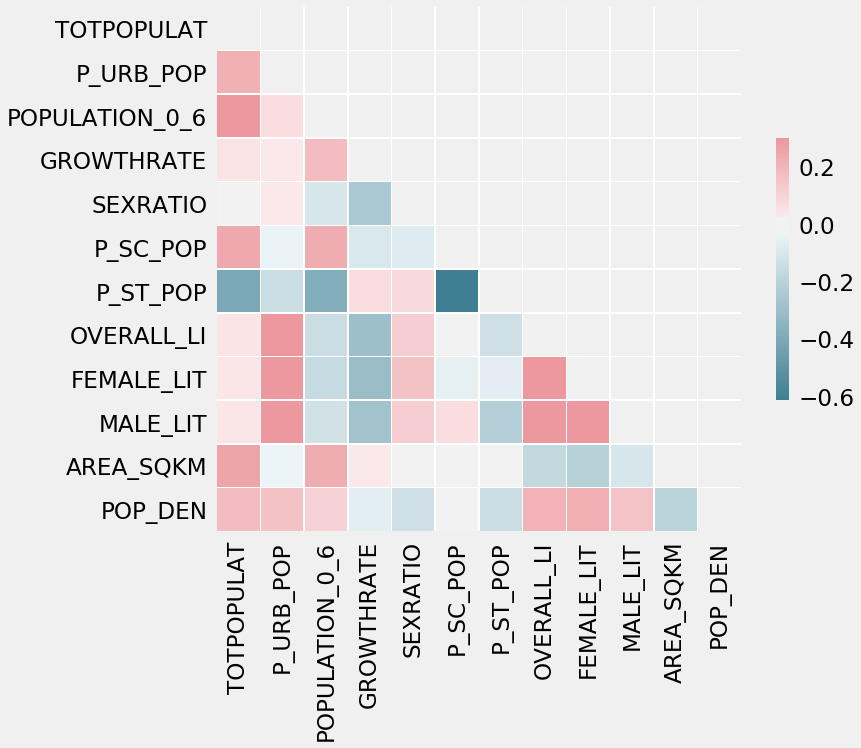

In [44]:
df['POP_DEN'] = df['TOTPOPULAT']/df['AREA_SQKM']
cols = ['TOTPOPULAT', 'P_URB_POP', 'POPULATION_0_6', 'GROWTHRATE', 'SEXRATIO', 'P_SC_POP', 'P_ST_POP', 'OVERALL_LI',
                'FEMALE_LIT', 'MALE_LIT', 'AREA_SQKM', 'POP_DEN']
df_sub = df[cols].dropna()
corr = df_sub.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=0.5, cbar_kws={'shrink':0.5})

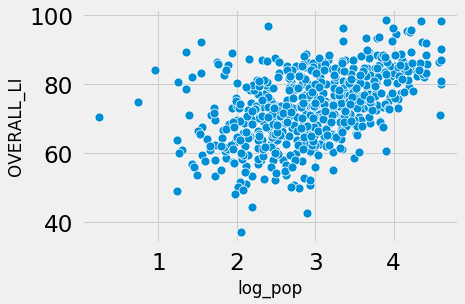

In [45]:
df_sub = df_sub[df_sub.P_URB_POP > 0]
df_sub['log_pop'] = np.log(df_sub.P_URB_POP)
df_sub = df_sub.dropna()
sns.scatterplot(x='log_pop', y='OVERALL_LI', data=df_sub)

# Bayesian Linear Regression using PyMC3

We are interested not only in obtaining a line of best fit, but also estimates of uncertainity in the line and the parameters used to calculate the line

In [46]:
from pymc3 import Normal, Model, HalfCauchy

with Model() as literacy_model:
    intercept = Normal('intercept', 0, sd=20)
    log_pop_coeff = Normal('coeff', 0, sd=20)
    sigma = HalfCauchy('sigma', beta=10, testval=1.)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [47]:
with literacy_model:
    
    mu = intercept + log_pop_coeff*df_sub.log_pop
    likelihood = Normal('yhat', mu=mu, sd=sigma, observed=df_sub.OVERALL_LI, testval=70)

In [48]:
from pymc3 import sample, fit, sgd

with literacy_model:
    literacy_sample = sample(3000, cores=2)#fit(1000, random_seed=RANDOM_SEED, method='svgd', obj_optimizer=sgd(learning_rate=2e-4), 
                      #       inf_kwargs=dict(n_particles=5))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, coeff, intercept]
The acceptance probability does not match the target. It is 0.9231351348416679, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7bf8f033d0>,
      dtype=object)

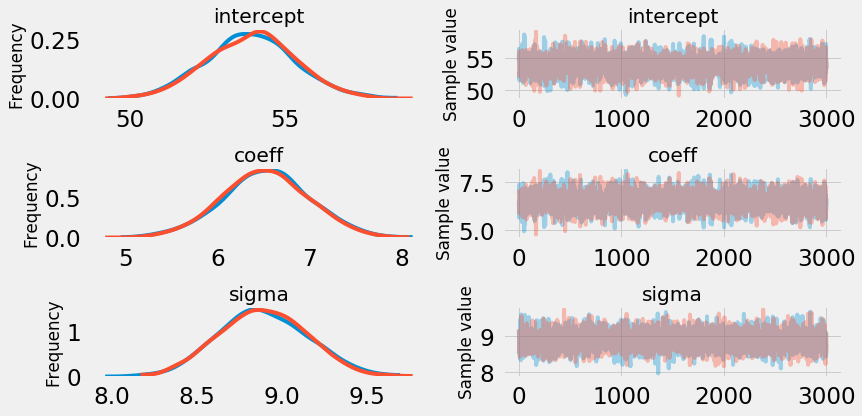

In [49]:
from pymc3 import traceplot

traceplot(literacy_sample)

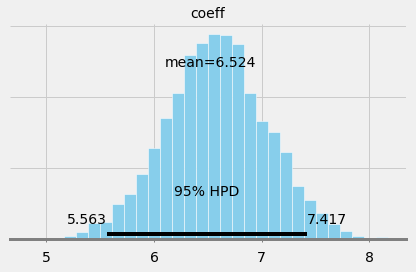

In [50]:
from pymc3 import plot_posterior
plot_posterior(literacy_sample, varnames=['coeff'])

# Checking model fit

Sample from the fitted model and check if it resembles the original data.

    p(ysample | y) = integral p(ysample | theta) * p(theta | y) dtheta

In [51]:
from pymc3 import sample_ppc

with literacy_model:
    literacy_ppc = sample_ppc(literacy_sample, 1000)

/home/a635137/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
100%|██████████| 1000/1000 [00:00<00:00, 1498.19it/s]


In [52]:
literacy_ppc['yhat'].shape

(1000, 623)

In [53]:
df_sub.shape

(623, 13)

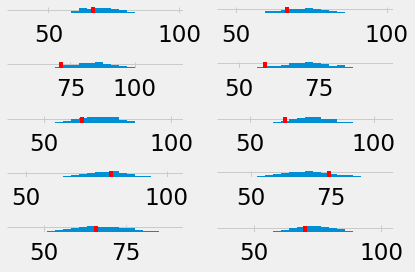

In [54]:
fig, axes = plt.subplots(5, 2)
axes_flat = axes.flatten()

for ax, real_data, sim_data in zip(axes_flat, df_sub.OVERALL_LI[:10], literacy_ppc['yhat'].T[:10]):
    ax.hist(sim_data, bins=20)
    ax.vlines(real_data, *ax.get_ylim(), colors='red')
    ax.set_yticklabels([])
    sns.despine(left=True)

plt.tight_layout()

# General Linear Regression in Pymc3

In [55]:
from pymc3 import glm

In [56]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula('OVERALL_LI ~ log_pop', df_sub)
    trace = sample(3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, log_pop, Intercept]
The acceptance probability does not match the target. It is 0.9910377698454846, but should be close to 0.8. Try to increase the number of tuning steps.


<Figure size 504x504 with 0 Axes>

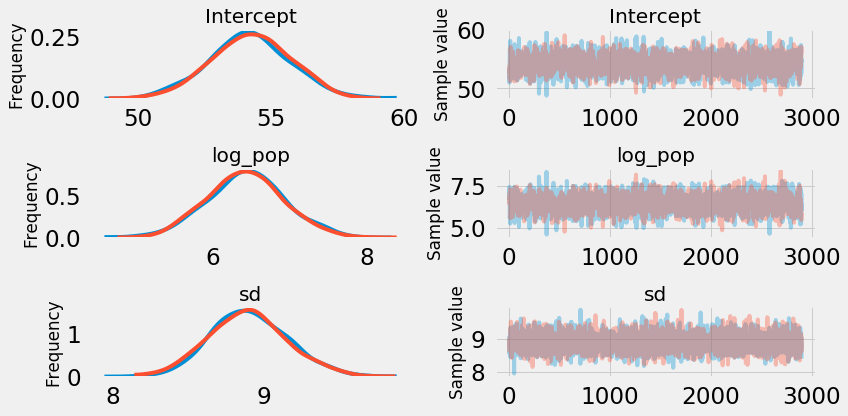

In [57]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout()

In [58]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula('OVERALL_LI ~ P_URB_POP + SEXRATIO', df_sub)
    trace = sample(3000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, SEXRATIO, P_URB_POP, Intercept]
The acceptance probability does not match the target. It is 0.9997073798796379, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9654591782221162, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<Figure size 1224x1224 with 0 Axes>

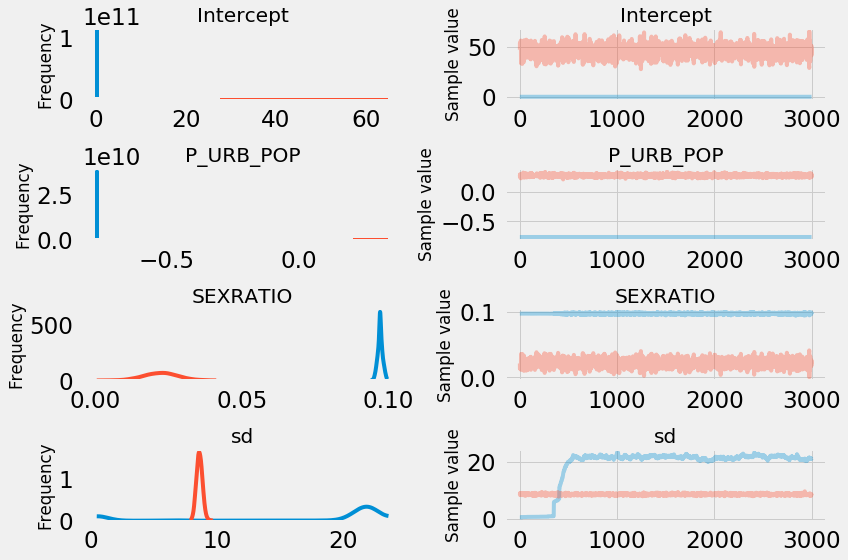

In [59]:
plt.figure(1, figsize=(17, 17))
# fig.add_axes([0, 0, 1, 1])
# plt.gca()
traceplot(trace)
plt.tight_layout()